##Catboost Model

In [1]:
#!pip install catboost
#!pip install lightgbm

#!pip install imblearn

In [2]:
from sklearn.ensemble import RandomForestClassifier
# from sklearn.naive_bayes import GaussianNB
# from sklearn.linear_model import LogisticRegression
# from sklearn.neighbors import KNeighborsClassifier
import os
import sys
import datacube
import joblib
import numpy as np
import pandas as pd
from joblib import dump
import subprocess as sp
import dask.array as da
from pprint import pprint
import matplotlib.pyplot as plt
from odc.io.cgroups import get_cpu_quota
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, auc, balanced_accuracy_score

from deafrica_tools.classification import spatial_clusters, SKCV, HiddenPrints, spatial_train_test_split

from IPython.display import Image
from odc.io.cgroups import get_cpu_quota
from sklearn import tree, model_selection
from sklearn.metrics import accuracy_score
from datacube.utils.cog import write_cog
from io import StringIO
import pydotplus
from sklearn import tree, model_selection
from sklearn.metrics import accuracy_score
from datacube.utils.cog import write_cog

from deafrica_tools.plotting import map_shapefile, rgb
from deafrica_tools.classification import predict_xr, collect_training_data
from deafrica_tools.bandindices import calculate_indices
%matplotlib inline

import datacube

from deafrica_tools.datahandling import mostcommon_crs
from deafrica_tools.spatial import xr_vectorize, xr_rasterize
import numpy as np
import matplotlib.pyplot as plt
sys.path.append('../Scripts')
from sklearn.model_selection import ShuffleSplit, GroupShuffleSplit, GroupKFold

%load_ext autoreload
%autoreload 2

/env/lib/python3.8/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  warnings.warn(
/env/lib/python3.8/site-packages/datacube/storage/masking.py:7: DeprecationWarning: datacube.storage.masking has moved to datacube.utils.masking
  warnings.warn("datacube.storage.masking has moved to datacube.utils.masking",


In [3]:
#Import the required packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
#-------------------------------------------------
import lightgbm as lgbm
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from catboost import Pool, CatBoostClassifier
from sklearn.metrics import log_loss

from sklearn.model_selection import train_test_split
#---------------------------------------------------
from sklearn.cluster import KMeans
# from featexp import get_univariate_plots
from imblearn.under_sampling import ClusterCentroids
from imblearn.under_sampling import TomekLinks
from sklearn.decomposition import PCA

In [4]:
#load the dataset
import pathlib
dataframe = pd.read_csv('data/Clean_kofadata.csv')
dataframe = dataframe.drop(['lon','lat'], axis= True)

In [5]:
dataframe.head()

,B01,B02,B03,B04,B05,B06,B07,B08,Grown_crop
0,357,346,776,776,766,2154,3261,3380,1
1,471,300,626,686,654,1997,3380,3345,1
2,402,320,829,803,700,2175,3604,3534,1
3,449,248,812,643,527,2921,5234,5860,1
4,363,253,658,644,546,2152,3479,3670,1


Calculating the vegetation indeces

In [6]:
#NDVI (Normalized Difference Vegetation Index) :(nir-red)/(nir+red)
# NDVI :(B8A-B04)/(B8A+B04)
dataframe['NDVI'] = (dataframe['B08']-dataframe['B04'])/(dataframe['B08']+dataframe['B04'])
#linear dimensionality reduction technique 
#pca=PCA(1)
#dataframe["NDVI"]=pca.fit_transform(dataframe['NDVI'])  
dataframe['water'] = dataframe['NDVI'].apply(lambda x :1 if x<0 else 0)
dataframe['dense_green'] = dataframe['NDVI'].apply(lambda x :1 if x>=0.5 else 0)
dataframe['not_green'] = dataframe['NDVI'].apply(lambda x :1 if( (x>0) & (x<0.5)) else 0)
# df = df.drop(NDVI,1)

# ARVI Atmospherice resistant vegetational Index)  (nir-2*red+blue)/(nir+2*red+blue)
dataframe['ARVI'] = (dataframe['B08']-2*dataframe['B05']+dataframe['B02'])/(dataframe['B08']+dataframe['B05']+dataframe['B02'])
#linear dimensionality reduction technique 

# SAVI (Soil adjusted Vegetation Index) :1.5*(nir-red)/(nir+red+0.5)
# SAVI :1.5*(B8A-B04)/(B8A+B04+0.5)
dataframe['SAVI'] = 1.5*(dataframe['B08']-dataframe['B05'])/(dataframe['B08']+dataframe['B05']+0.5)
#linear dimensionality reduction technique 
dataframe['high_green'] = dataframe['SAVI'].apply(lambda x :1 if x<0.1 else 0)
dataframe['low_green'] = dataframe['SAVI'].apply(lambda x :1 if x>=0.8 else 0)
#df = df.drop(SAVI,1)

#Normalized Difference RedEdge
# NDRE :(B08-B05)/(B08+B05)
dataframe['NDRE'] =  (dataframe['B08']-dataframe['B05'])/(dataframe['B08']+dataframe['B05'])

#Red-edge chlorophyll index
#RECI :(B08/B05)-1
dataframe['RECI'] = ((dataframe['B08'])/(dataframe['B05']))-1

# ARVI  (nir-2*red+blue)/(nir+2*red+blue)
dataframe['ARVI'] = (dataframe['B08']-2*dataframe['B05']+dataframe['B02'])/(dataframe['B08']+dataframe['B05']+dataframe['B02'])

#Enhanced vegetation Index
#EVI :2.5*((nir-red)/(nir+6*red-7.5*blue+1))
#EVI :2.5*((B8A-B04)/(B8A+6*B04-7.5*B02+1))
dataframe['EVI'] = 2.5*((dataframe['B08']-dataframe['B05'])/(dataframe['B08']+6*dataframe['B05']-7.5*dataframe['B02']+1))

dataframe['chlorophyll_EVI'] = dataframe['EVI'].apply(lambda x :1 if( (x>0.2) & (x<0.8)) else 0)

#Structure Insensitive Pigment Index
#SIPI : (B08-B02)/(B08-B05)
dataframe['SIPI'] = (dataframe['B08']-dataframe['B02'])/(dataframe['B08']-dataframe['B05'])

dataframe['carotenoids'] = dataframe['SIPI'].apply(lambda x :1 if x>0 else 0)
dataframe['chlorophyll-SIPI'] = dataframe['SIPI'].apply(lambda x :1 if x<=0 else 0)  

# Green Chlorophyll Index
#GCI: (nir)-(green) -1
dataframe['GCI'] = (dataframe['B08'])/(dataframe['B03'])-1

In [7]:
dataframe.head()

,B01,B02,B03,B04,B05,B06,B07,B08,Grown_crop,NDVI,...,high_green,low_green,NDRE,RECI,EVI,chlorophyll_EVI,SIPI,carotenoids,chlorophyll-SIPI,GCI
0,357,346,776,776,766,2154,3261,3380,1,0.626564,...,0,1,0.630487,3.412533,1.214233,0,1.160673,1,0,3.355670
1,471,300,626,686,654,1997,3380,3345,1,0.659638,...,0,1,0.672918,4.114679,1.340139,0,1.131550,1,0,4.343450
2,402,320,829,803,700,2175,3604,3534,1,0.629698,...,0,1,0.669343,4.048571,1.328022,0,1.134086,1,0,3.262967
3,449,248,812,643,527,2921,5234,5860,1,0.802245,...,0,1,0.834977,10.119545,1.861301,0,1.052316,1,0,6.216749
4,363,253,658,644,546,2152,3479,3670,1,0.701437,...,0,1,0.740987,5.721612,1.546688,0,1.093790,1,0,4.577508


In [8]:
dataframe = dataframe[['B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08',
       'NDVI', 'water', 'dense_green', 'not_green', 'ARVI', 'SAVI',
       'high_green', 'low_green', 'NDRE', 'RECI', 'EVI', 'chlorophyll_EVI',
       'SIPI', 'carotenoids', 'chlorophyll-SIPI', 'GCI','Grown_crop']]

In [9]:
dataframe = dataframe.drop(['water', 'dense_green', 'not_green','high_green', 'low_green','chlorophyll_EVI',
                            'carotenoids', 'chlorophyll-SIPI'],axis=1)

In [10]:
def stratify_data(df_data, stratify_column_name, stratify_values, stratify_proportions, random_state=None):
    """Stratifies data according to the values and proportions passed in
    Args:
        df_data (DataFrame): source data
        stratify_column_name (str): The name of the single column in the dataframe that holds the data values that will be used to stratify the data
        stratify_values (list of str): A list of all of the potential values for stratifying e.g. "Male, Graduate", "Male, Undergraduate", "Female, Graduate", "Female, Undergraduate"
        stratify_proportions (list of float): A list of numbers representing the desired propotions for stratifying e.g. 0.4, 0.4, 0.2, 0.2, The list values must add up to 1 and must match the number of values in stratify_values
        random_state (int, optional): sets the random_state. Defaults to None.
    Returns:
        DataFrame: a new dataframe based on df_data that has the new proportions represnting the desired strategy for stratifying
    """
    df_stratified = pd.DataFrame(columns = df_data.columns) # Create an empty DataFrame with column names matching df_data

    pos = -1
    for i in range(len(stratify_values)): # iterate over the stratify values (e.g. "Male, Undergraduate" etc.)
        pos += 1
        if pos == len(stratify_values) - 1: 
            ratio_len = len(df_data) - len(df_stratified) # if this is the final iteration make sure we calculate the number of values for the last set such that the return data has the same number of rows as the source data
        else:
            ratio_len = int(len(df_data) * stratify_proportions[i]) # Calculate the number of rows to match the desired proportio
        df_filtered = df_data[df_data[stratify_column_name] ==stratify_values[i]] # Filter the source data based on the currently selected stratify value
        df_temp = df_filtered.sample(replace=True, n=ratio_len, random_state=random_state) # Sample the filtered data using the calculated ratio
        
        df_stratified = pd.concat([df_stratified, df_temp]) # Add the sampled / stratified datasets together to produce the final result
        
    return df_stratified # Return the stratified, re-sampled data  
#stratify_values = [, 'Male, Rent', 'Female, Home Mortgage', 'Female, Rent']
stratify_values = [0,1,2,3,4]
stratify_proportions = [0.10,0.20, 0.20, 0.25, 0.25]
df_stratified = stratify_data(dataframe, 'Grown_crop', stratify_values, stratify_proportions, random_state=12345)
df_stratified.reset_index()

,index,B01,B02,B03,B04,B05,B06,B07,B08,NDVI,ARVI,SAVI,NDRE,RECI,EVI,SIPI,GCI,Grown_crop
0,57006,247,95,494,267,199,1935,4113,4174,0.879757,0.866383,1.363325,0.908987,19.974874,2.134114,1.026164,7.449393,0
1,86889,214,75,329,172,157,1303,3390,3023,0.892332,0.855300,1.351674,0.901258,18.254777,2.105186,1.028611,8.188450,0
2,54605,304,191,522,353,405,1908,3832,4154,0.843355,0.744211,1.233359,0.822329,9.256790,1.819020,1.057082,6.957854,0
3,55920,201,66,437,235,137,1706,3593,3843,0.884747,0.898418,1.396558,0.931156,27.051095,2.221290,1.019158,7.794050,0
4,86829,307,169,560,525,356,2400,4987,4571,0.793956,0.790424,1.283105,0.855490,11.839888,1.936862,1.044365,7.162500,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89948,78377,368,219,491,469,488,1126,1894,1834,0.592705,0.423849,0.869322,0.579673,2.758197,1.078353,1.199851,2.735234,4
89949,13075,353,341,684,831,759,1903,2744,2880,0.552142,0.427889,0.874159,0.582852,2.794466,1.087135,1.197077,3.210526,4
89950,27848,293,159,622,508,332,2514,4980,5059,0.817496,0.820541,1.315126,0.876832,14.237952,2.016810,1.036598,7.133441,4
89951,15573,308,228,747,532,485,2052,4312,3983,0.764341,0.690162,1.174220,0.782901,7.212371,1.686921,1.073471,4.331995,4


In [11]:
#save the dataframes as a csv file
dataframe.to_csv("data/pixel_data.csv", index = False)

In [12]:
df_stratified.to_csv("data/pixel_dataS.csv", index = False)

## Stratified Sampling

In [13]:
type(df_stratified)

pandas.core.frame.DataFrame

In [14]:
df_stratified.replace(to_replace = np.nan, value =0)

,B01,B02,B03,B04,B05,B06,B07,B08,NDVI,ARVI,SAVI,NDRE,RECI,EVI,SIPI,GCI,Grown_crop
57006,247,95,494,267,199,1935,4113,4174,0.879757,0.866383,1.363325,0.908987,19.974874,2.134114,1.026164,7.449393,0
86889,214,75,329,172,157,1303,3390,3023,0.892332,0.855300,1.351674,0.901258,18.254777,2.105186,1.028611,8.188450,0
54605,304,191,522,353,405,1908,3832,4154,0.843355,0.744211,1.233359,0.822329,9.256790,1.819020,1.057082,6.957854,0
55920,201,66,437,235,137,1706,3593,3843,0.884747,0.898418,1.396558,0.931156,27.051095,2.221290,1.019158,7.794050,0
86829,307,169,560,525,356,2400,4987,4571,0.793956,0.790424,1.283105,0.855490,11.839888,1.936862,1.044365,7.162500,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78377,368,219,491,469,488,1126,1894,1834,0.592705,0.423849,0.869322,0.579673,2.758197,1.078353,1.199851,2.735234,4
13075,353,341,684,831,759,1903,2744,2880,0.552142,0.427889,0.874159,0.582852,2.794466,1.087135,1.197077,3.210526,4
27848,293,159,622,508,332,2514,4980,5059,0.817496,0.820541,1.315126,0.876832,14.237952,2.016810,1.036598,7.133441,4
15573,308,228,747,532,485,2052,4312,3983,0.764341,0.690162,1.174220,0.782901,7.212371,1.686921,1.073471,4.331995,4


In [15]:
data =pd.read_csv('data/pixel_data.csv')

In [16]:
# Split into train and test sets
train, test = train_test_split(dataframe, test_size=0.2,shuffle=True)
train, val = train_test_split(train, test_size=0.2,shuffle=True)

X_train, y_train = train.iloc[:,0:16], train.Grown_crop
X_val, y_val = val.iloc[:,0:16], val.Grown_crop
X_test, y_test = test.iloc[:,0:16], test.Grown_crop

print(len(train), 'train examples')
print(len(val), 'validation examples')
print(len(test), 'test examples')

57569 train examples
14393 validation examples
17991 test examples


In [17]:
X_train.head()

,B01,B02,B03,B04,B05,B06,B07,B08,NDVI,ARVI,SAVI,NDRE,RECI,EVI,SIPI,GCI
70165,325,206,621,454,440,1847,3609,3372,0.762676,0.671478,1.153574,0.769150,6.663636,1.640555,1.079809,4.429952
54370,409,282,837,743,605,2270,3873,3866,0.677587,0.618136,1.093928,0.729367,5.390083,1.514771,1.099049,3.618877
6842,387,162,591,441,339,2308,4615,4661,0.827127,0.802983,1.296470,0.864400,12.749263,1.971356,1.040953,6.886633
46377,388,210,640,458,447,1867,3609,3893,0.789474,0.705275,1.190877,0.794009,7.709172,1.722655,1.068775,5.082813
22987,213,128,654,512,267,2152,4222,4799,0.807193,0.845784,1.341755,0.894591,16.973783,2.081955,1.030671,6.337920


In [18]:
y_test.unique()

array([1, 0, 3, 4, 2])

In [19]:
X_train.columns

Index(['B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'NDVI', 'ARVI',
       'SAVI', 'NDRE', 'RECI', 'EVI', 'SIPI', 'GCI'],
      dtype='object')

Model :

In [20]:
model =  CatBoostClassifier(
    iterations=100,
    learning_rate=0.001,
    random_strength=0.1,
    depth=10,
    loss_function='MultiClass'
)

model.fit(X_train,
          y_train,
          cat_features=None,
          eval_set=(X_val, y_val),
          plot=True
         )

train_score = model.score(X_train, y_train) # train (learn) score

val_score = model.score(X_val, y_val) # val (test) score
test_score = model.score(X_test, y_test) # val (test) score


# Get predicted probabilities
preds = model.predict_proba(X_val.fillna(0))

# Add to val_grouped dataframe as columns
for i in range(5):
      val[str(i+1)] = preds[:,i]

# Get 'true' vals as columns in val
for c in range(1, 6):
      val['true'+str(c)] = (val['Grown_crop'] == c).astype(int)

pred_cols = [str(i) for i in range(1, 6)]
true_cols = ['true'+str(i) for i in range(1, 6)]
val[['Grown_crop']+true_cols+pred_cols].head()

# Already grouped, but just to double check:
print('Field score:', log_loss(val[true_cols], val[pred_cols]))

preds = model.predict_proba(X_test)

prob_df = pd.DataFrame({
    'True_crops':test['Grown_crop'].values
})
for c in range(1, 6):
    prob_df['Crop_ID_'+str(c)] = preds[:,c-1]
prob_df.head()

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 1.6080244	test: 1.6080334	best: 1.6080334 (0)	total: 402ms	remaining: 39.8s
1:	learn: 1.6066372	test: 1.6066602	best: 1.6066602 (1)	total: 747ms	remaining: 36.6s
2:	learn: 1.6052474	test: 1.6052797	best: 1.6052797 (2)	total: 1.12s	remaining: 36.1s
3:	learn: 1.6038558	test: 1.6038957	best: 1.6038957 (3)	total: 1.48s	remaining: 35.5s
4:	learn: 1.6024620	test: 1.6025083	best: 1.6025083 (4)	total: 1.83s	remaining: 34.8s
5:	learn: 1.6011000	test: 1.6011603	best: 1.6011603 (5)	total: 2.17s	remaining: 34s
6:	learn: 1.5997191	test: 1.5997903	best: 1.5997903 (6)	total: 2.51s	remaining: 33.4s
7:	learn: 1.5983468	test: 1.5984258	best: 1.5984258 (7)	total: 2.87s	remaining: 33s
8:	learn: 1.5969774	test: 1.5970622	best: 1.5970622 (8)	total: 3.2s	remaining: 32.4s
9:	learn: 1.5956148	test: 1.5957075	best: 1.5957075 (9)	total: 3.56s	remaining: 32.1s
10:	learn: 1.5942572	test: 1.5943625	best: 1.5943625 (10)	total: 3.9s	remaining: 31.5s
11:	learn: 1.5929049	test: 1.5930167	best: 1.5930167 (11)	

,True_crops,Crop_ID_1,Crop_ID_2,Crop_ID_3,Crop_ID_4,Crop_ID_5
0,1,0.196133,0.244351,0.186408,0.189762,0.183346
1,0,0.196482,0.242872,0.187288,0.189937,0.183421
2,1,0.196819,0.243046,0.186448,0.190538,0.183149
3,1,0.195580,0.244102,0.186364,0.190284,0.183670
4,1,0.195542,0.245525,0.186561,0.189460,0.182912


In [21]:
train_score

0.6693011864024041

In [22]:
val_score

0.667546724101994

In [23]:
test_score

0.6643321660830416

In [24]:
#Reandom forest

# Fit and score a baseline RandomForestClassifier
forest1 = RandomForestClassifier(n_estimators=500,criterion = 'entropy', random_state = 2)
forest1.fit(X_train, y_train)

train_pred = forest1.predict(X_train)

#print_metrics(train_labels, train_pred)
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix 
import numpy as np
print(np.mean(train_pred != y_train))
print(confusion_matrix(y_train, train_pred))  
print(classification_report(y_train, train_pred)) 
print("Accuracy:", metrics.accuracy_score(y_train, train_pred))

0.002466605291042054
[[ 9034     1     0     0     0]
 [    0 38482     5    42     2]
 [    0    36  3157     3     5]
 [    0    45     1  5464     0]
 [    0     1     1     0  1290]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9035
           1       1.00      1.00      1.00     38531
           2       1.00      0.99      0.99      3201
           3       0.99      0.99      0.99      5510
           4       0.99      1.00      1.00      1292

    accuracy                           1.00     57569
   macro avg       1.00      0.99      1.00     57569
weighted avg       1.00      1.00      1.00     57569

Accuracy: 0.997533394708958


In [25]:
y_test.unique()

array([1, 0, 3, 4, 2])

In [26]:
# Validate
val_pred = forest1.predict(X_val)

print(np.mean(val_pred != y_val))
print(confusion_matrix(y_val, val_pred))  
print(classification_report(y_val, val_pred)) 
print("Accuracy:", metrics.accuracy_score(y_val, val_pred))

0.15695129576877648
[[1420  855    0    0    0]
 [   6 9570    3   26    3]
 [   3  364  407    3    6]
 [   1  792    3  640    0]
 [   1  192    1    0   97]]
              precision    recall  f1-score   support

           0       0.99      0.62      0.77      2275
           1       0.81      1.00      0.90      9608
           2       0.98      0.52      0.68       783
           3       0.96      0.45      0.61      1436
           4       0.92      0.33      0.49       291

    accuracy                           0.84     14393
   macro avg       0.93      0.58      0.69     14393
weighted avg       0.87      0.84      0.83     14393

Accuracy: 0.8430487042312235


In [27]:
# Validate
test_pred = forest1.predict(X_test)

print(np.mean(test_pred != y_test))
print(confusion_matrix(y_test, test_pred))  
print(classification_report(y_test, test_pred)) 
print("Accuracy:", metrics.accuracy_score(y_test, test_pred))

0.15680062253348898
[[ 1787  1060     0     0     0]
 [   19 11902     6    25     0]
 [    1   444   569     2     6]
 [    2   987     1   778     0]
 [    0   265     3     0   134]]
              precision    recall  f1-score   support

           0       0.99      0.63      0.77      2847
           1       0.81      1.00      0.89     11952
           2       0.98      0.56      0.71      1022
           3       0.97      0.44      0.60      1768
           4       0.96      0.33      0.49       402

    accuracy                           0.84     17991
   macro avg       0.94      0.59      0.69     17991
weighted avg       0.87      0.84      0.83     17991

Accuracy: 0.8431993774665111


In [28]:
def roc_it(y_true, y_pred, model_name, figsize=(12,10)):
    '''Plot ROC with a separate curve for each class.
    
        Keyword arguments:
    y_true: ground-truth labels
    y_pred: predicted labels
    model_name: name to print in the plot title
    
    Dependencies:
    pandas aliased as pd
    sklearn.metrics.roc_curve
    sklearn.metrics.auc
    matplotlib.pyplot aliased as plt
    '''
    y_true_dum = pd.get_dummies(y_true.astype(int))
    y_pred_dum = pd.get_dummies(y_pred)
    n_classes = np.unique(y_pred.astype(int))#y_true.unique()
    
    fprs = []
    tprs = []
    aucs = []

    for i in range(0,len(n_classes)):
        fpr, tpr, _ = roc_curve(y_true_dum.loc[:,i], y_pred_dum.loc[:,i])
        fprs.append(fpr)
        tprs.append(tpr)
        aucs.append(round(auc(fpr, tpr),2))
        
    plt.figure(figsize=(12,10))
    for i in range(len(n_classes)):
        plt.plot(fprs[i], tprs[i], label='Class: {}, AUC: {}'.format(i+1, 
                                                                     aucs[i]))
    plt.plot([0.0,1.0], [0.0,1.0], linestyle='--')
    plt.title('ROC curves by class for {}'.format(model_name))
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend();


In [29]:
# Define a function to visualize a confusion matrix
def pretty_confusion(y_true, y_pred, model_name):
    '''Display normalized confusion matrix with color scale.
    
    Note that this function works specifically for data from the 
    Forest Cover Types dataset. 
    
    Keyword arguments:
    y_true: ground-truth labels
    y_pred: predicted labels
    model_name: name to print in the plot title
    
    Dependencies:
    numpy aliased as np
    sklearn.metrics.confusion_matrix
    matplotlib.pyplot aliased as plt
    seaborn aliased as sns
    '''
    
    # Calculate the confusion matrix
    matrix = confusion_matrix(y_true, y_pred)
    matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]
    
    # Build the plot
    plt.figure(figsize=(16,7))
    sns.set(font_scale=1.4)
    sns.heatmap(matrix, annot=True, annot_kws={'size':10},
                cmap=plt.cm.Greens, linewidths=0.2)
    
    # Add labels to the plot
    class_names = ['millet, soybeans', 'soybeans, sorghum', 'rice, sorghum',
       'groundnut, sorghum', 'maize, sorghum']
    tick_marks = np.arange(len(class_names))
    tick_marks2 = tick_marks + 0.5
    plt.xticks(tick_marks, class_names, rotation=25)
    plt.yticks(tick_marks2, class_names, rotation=0)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title('Confusion Matrix for {}'.format(model_name)) 
    plt.tight_layout()
    
    
# Define a function to save a confusion matrix visualization    
def save_conf_matrix(y_true, y_pred, model_name):
    '''Save normalized confusion matrix with color scale as .png file.
    
    Note that in Jupyter Notebook, the plot will also be displayed
    automatically on calling this function. This function saves .png files
    with 300 dpi and 0.5-in. padding.
    
    Keyword arguments:
    y_true: ground-truth labels
    y_pred: predicted labels
    model_name: name to print in the plot title
    
    Dependencies:
    sklearn.metrics.confusion_matrix
    matplotlib.pyplot aliased as plt
    seaborn aliased as sns
    '''
    fig = pretty_confusion(y_true, y_pred, model_name)
    filename = '_'.join(model_name.split()) + '_confmatrix.png'
    plt.savefig(filename, pad_inches=0.5, dpi=300)

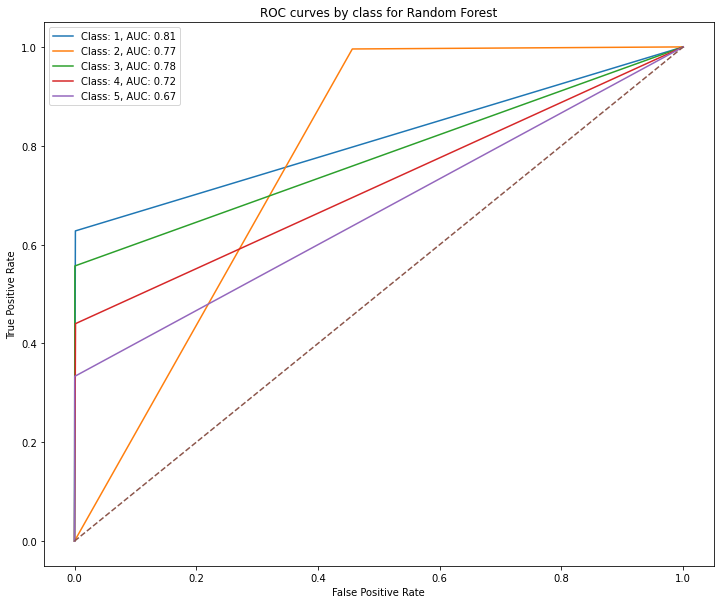

In [30]:
# Plot ROC curve for each class
roc_it(y_test, test_pred,'Random Forest')
plt.savefig('Results/Roc_rf_test.png')

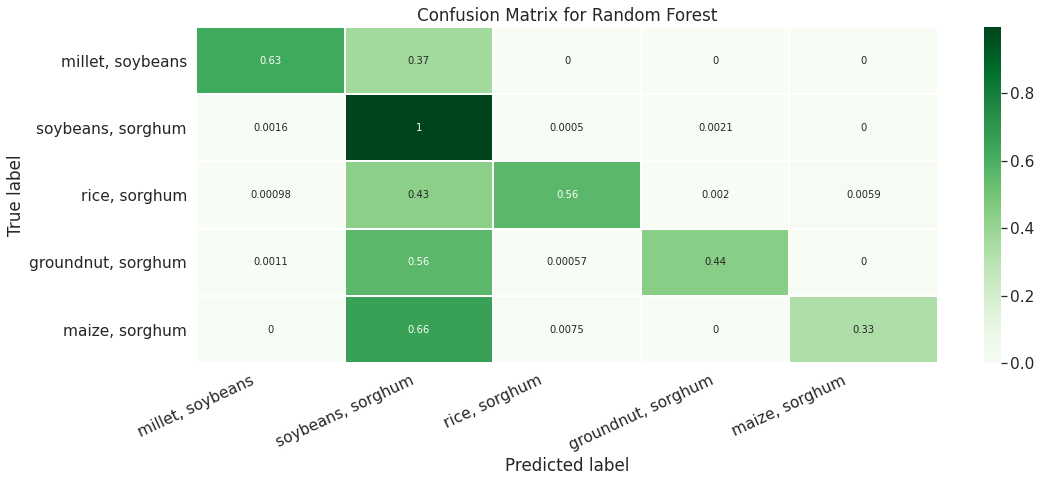

In [31]:
#View confusion matrix for Random Forest 1
save_conf_matrix(y_test, test_pred, 'Random Forest')

In [32]:
rf = RandomForestClassifier(n_estimators=500, random_state=12345)

rf.fit(X_train, y_train)

preds = rf.predict_proba(X_val)

In [33]:
rf_preds =  rf.predict(X_val)

accuracy_score(y_val, rf_preds)

0.8429792260126451

In [34]:
unique_lbls = np.unique(y_val)

f1_scores = metrics.f1_score(y_val, rf_preds, labels=unique_lbls, average=None)
recall = metrics.recall_score(y_val, rf_preds, labels=unique_lbls, average=None)
precision = metrics.precision_score(y_val, rf_preds, labels=unique_lbls, average=None)
    
for idx, class_id in enumerate(unique_lbls):
    print(f'        * class {class_id:5d} = {f1_scores[idx]*100:2.1f} | {recall[idx]*100:2.1f} | {precision[idx]*100:2.1f} | {np.count_nonzero(y_val==class_id):8d}')

        * class     0 = 76.6 | 62.5 | 98.9 |     2275
        * class     1 = 89.5 | 99.6 | 81.3 |     9608
        * class     2 = 68.0 | 52.0 | 98.3 |      783
        * class     3 = 60.8 | 44.6 | 95.5 |     1436
        * class     4 = 48.9 | 33.3 | 91.5 |      291


In [35]:
from sklearn import metrics
from sklearn.ensemble import ExtraTreesClassifier

#define and fit a ExtraTreeClassifier to the data
model = ExtraTreesClassifier()
model.fit(X_train,y_train)

#display the feature importance
print(model.feature_importances_)
print('\n',X_train.columns.values)

[0.06876101 0.06050402 0.06555637 0.06649531 0.06049617 0.06766798
 0.0686234  0.06202718 0.06668233 0.05745198 0.05780029 0.05700593
 0.0570229  0.05854406 0.05843421 0.06692686]

 ['B01' 'B02' 'B03' 'B04' 'B05' 'B06' 'B07' 'B08' 'NDVI' 'ARVI' 'SAVI'
 'NDRE' 'RECI' 'EVI' 'SIPI' 'GCI']


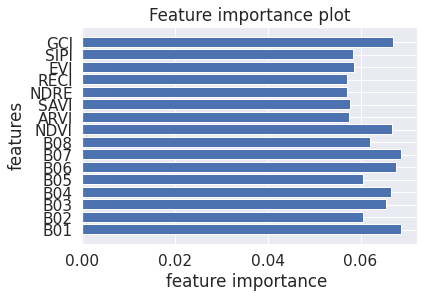

In [36]:
#bar plot of feature importance
values = model.feature_importances_
pos = np.arange(16) + 0.04
plt.barh(pos,values,align = 'center')
plt.title('Feature importance plot')
plt.xlabel('feature importance ')
plt.ylabel('features')
plt.yticks(np.arange(16),('B01', 'B02', 'B03', 'B04' ,'B05', 'B06', 'B07', 'B08', 'NDVI', 'ARVI', 'SAVI',
 'NDRE' ,'RECI' ,'EVI', 'SIPI', 'GCI'))
plt.grid(True)

In [37]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import model_selection
from sklearn.model_selection import GroupShuffleSplit, StratifiedKFold, cross_val_score, train_test_split, GridSearchCV
from sklearn import linear_model, svm, naive_bayes, neighbors, ensemble
from sklearn.metrics import precision_score, recall_score, precision_recall_curve,f1_score, fbeta_score, auc, plot_roc_curve
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

In [38]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import log_loss
from sklearn.utils import shuffle

In [39]:
knn = KNeighborsClassifier(n_neighbors=7)


knn.fit(X_train, y_train)

preds_knn = knn.predict_proba(X_val)

In [40]:
preds_knn

array([[0.        , 0.57142857, 0.        , 0.42857143, 0.        ],
       [0.        , 1.        , 0.        , 0.        , 0.        ],
       [0.42857143, 0.28571429, 0.        , 0.28571429, 0.        ],
       ...,
       [0.28571429, 0.71428571, 0.        , 0.        , 0.        ],
       [0.        , 0.42857143, 0.        , 0.57142857, 0.        ],
       [0.        , 1.        , 0.        , 0.        , 0.        ]])

In [41]:
knn_preds =  knn.predict(X_val)

accuracy_score(y_val, knn_preds)

0.6767873271729313

In [42]:
unique_lbls = np.unique(y_val)

f1_scores = metrics.f1_score(y_val, knn_preds, labels=unique_lbls, average=None)
recall = metrics.recall_score(y_val, knn_preds, labels=unique_lbls, average=None)
precision = metrics.precision_score(y_val, knn_preds, labels=unique_lbls, average=None)
#print(classification_report(y_val, knn_preds)) 
for idx, class_id in enumerate(unique_lbls):
    print(f'        * class {class_id:5d} = {f1_scores[idx]*100:2.1f} | {recall[idx]*100:2.1f} | {precision[idx]*100:2.1f} | {np.count_nonzero(y_val==class_id):8d}')

        * class     0 = 41.0 | 36.3 | 47.2 |     2275
        * class     1 = 80.0 | 89.0 | 72.6 |     9608
        * class     2 = 27.6 | 19.5 | 46.9 |      783
        * class     3 = 21.3 | 14.4 | 40.9 |     1436
        * class     4 = 0.6 | 0.3 | 4.0 |      291


In [43]:
import xgboost as xgb

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)
dval = xgb.DMatrix(X_val, label=y_val)

In [44]:
param = {
    'max_depth': 6,  # the maximum depth of each tree
    'eta': 0.20,  # the training step for each iteration
    'silent': 1,  # logging mode - quiet
    'n_jobs':4,
    #'learning_rate': 0.001,
    'n_estimators': 100,
    #'gamma': 0.1,
    #'min_child_weight':7,
    #'subsample': 0.7,
    #'colsample_by_level':0.4,
    #'colsample_by_tree':0.7,
    #'reg_alpha':np.log(1),
    'objective': 'multi:softprob',  # error evaluation for multiclass training
    'num_class': 5}  # the number of classes that exist in this datset
num_round = 550  # the number of training iterations

In [45]:
bst = xgb.train(param, dtrain, num_round)

[04:46:53] WARNING: ../src/learner.cc:573: 
Parameters: { "n_estimators", "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[04:46:54] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [46]:
preds = bst.predict(dtest)
best_preds = np.asarray([np.argmax(line) for line in preds])
print(np.mean(best_preds != y_test))
print(confusion_matrix(y_test, best_preds))  
print(classification_report(y_test, best_preds)) 
print("Accuracy:", metrics.accuracy_score(y_test, best_preds))

0.2194430548607637
[[ 1196  1651     0     0     0]
 [   55 11845    12    39     1]
 [    3   574   438     1     6]
 [    9  1305     1   453     0]
 [    1   290     0     0   111]]
              precision    recall  f1-score   support

           0       0.95      0.42      0.58      2847
           1       0.76      0.99      0.86     11952
           2       0.97      0.43      0.59      1022
           3       0.92      0.26      0.40      1768
           4       0.94      0.28      0.43       402

    accuracy                           0.78     17991
   macro avg       0.91      0.47      0.57     17991
weighted avg       0.82      0.78      0.74     17991

Accuracy: 0.7805569451392362


In [47]:
unique_lbls = np.unique(y_test)

f1_scores = metrics.f1_score(y_test, best_preds, labels=unique_lbls, average=None)
recall = metrics.recall_score(y_test, best_preds, labels=unique_lbls, average=None)
precision = metrics.precision_score(y_test, best_preds, labels=unique_lbls, average=None)
    
for idx, class_id in enumerate(unique_lbls):
    print(f'        * class {class_id:5d} = {f1_scores[idx]*100:2.1f} | {recall[idx]*100:2.1f} | {precision[idx]*100:2.1f} | {np.count_nonzero(y_val==class_id):8d}')

        * class     0 = 58.2 | 42.0 | 94.6 |     2275
        * class     1 = 85.8 | 99.1 | 75.6 |     9608
        * class     2 = 59.5 | 42.9 | 97.1 |      783
        * class     3 = 40.1 | 25.6 | 91.9 |     1436
        * class     4 = 42.7 | 27.6 | 94.1 |      291


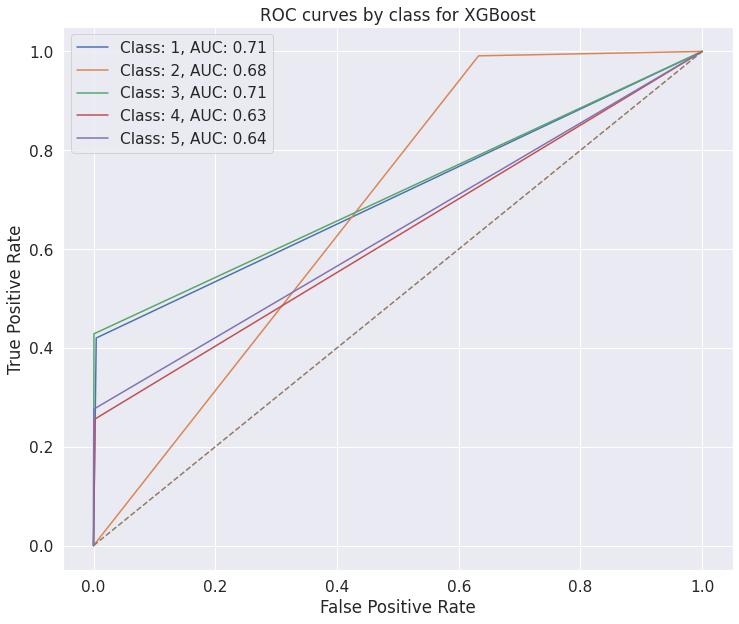

In [48]:
# Plot ROC curve for each class
roc_it(y_test, best_preds,'XGBoost')
plt.savefig('Results/Roc_XGB_test.png')

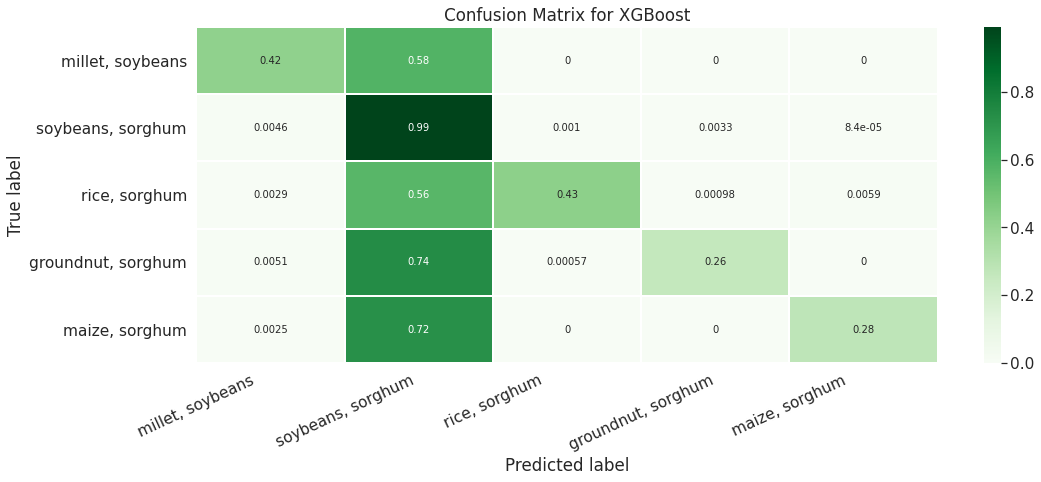

In [49]:
# View confusion matrix for Random Forest 1
save_conf_matrix(y_test, best_preds, 'XGBoost')

In [50]:
## Support vector machine
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.svm import SVC
parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]}
svc = svm.SVC()
#clf = GridSearchCV(svc, parameters)
clf = make_pipeline(StandardScaler(), SVC(C=1,gamma=1))



In [51]:
# View metrics for training data
clf.fit(X_train, y_train)
y_pred = clf.predict(X_train)
print(np.mean(y_pred != y_train))
print(confusion_matrix(y_train, y_pred))  
print(classification_report(y_train, y_pred)) 
print("Accuracy:", metrics.accuracy_score(y_train, y_pred))

0.3067275790790182
[[  903  8132     0     0     0]
 [   17 38511     2     1     0]
 [   10  2926   265     0     0]
 [   11  5291     1   207     0]
 [    2  1264     1     0    25]]
              precision    recall  f1-score   support

           0       0.96      0.10      0.18      9035
           1       0.69      1.00      0.81     38531
           2       0.99      0.08      0.15      3201
           3       1.00      0.04      0.07      5510
           4       1.00      0.02      0.04      1292

    accuracy                           0.69     57569
   macro avg       0.92      0.25      0.25     57569
weighted avg       0.78      0.69      0.59     57569

Accuracy: 0.6932724209209817


In [52]:
# View metrics for training data
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(np.mean(y_pred != y_test))
print(confusion_matrix(y_test, y_pred))  
print(classification_report(y_test, y_pred)) 
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))

0.32099383024845757
[[  204  2643     0     0     0]
 [   22 11929     1     0     0]
 [    2   974    46     0     0]
 [    3  1730     0    35     0]
 [    0   399     1     0     2]]
              precision    recall  f1-score   support

           0       0.88      0.07      0.13      2847
           1       0.67      1.00      0.81     11952
           2       0.96      0.05      0.09      1022
           3       1.00      0.02      0.04      1768
           4       1.00      0.00      0.01       402

    accuracy                           0.68     17991
   macro avg       0.90      0.23      0.21     17991
weighted avg       0.76      0.68      0.56     17991

Accuracy: 0.6790061697515425


In [53]:
!pip install scikit-multilearn

In [54]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import model_selection
from sklearn.model_selection import GroupShuffleSplit, StratifiedKFold, cross_val_score, train_test_split, GridSearchCV
from sklearn import linear_model, svm, naive_bayes, neighbors, ensemble
from sklearn.metrics import precision_score, recall_score, precision_recall_curve,f1_score, fbeta_score, auc, plot_roc_curve
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix


import tensorflow
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Conv1D, MaxPooling1D, Flatten

import pandas
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split

In [55]:
# Split into train and test sets
train, test = train_test_split(dataframe, test_size=0.2)
train, val = train_test_split(train, test_size=0.2)

X_train, y_train = train.iloc[:,0:24], train.Grown_crop
X_val, y_val = val.iloc[:,0:24], val.Grown_crop
X_test, y_test = test.iloc[:,0:24], test.Grown_crop

print(len(train), 'train examples')
print(len(val), 'validation examples')
print(len(test), 'test examples')

57569 train examples
14393 validation examples
17991 test examples


In [56]:
# encode class values as integers
encoder = LabelEncoder()
encoder.fit(y_train)
encoded_Y = encoder.transform(y_train)
# convert integers to dummy variables (i.e. one hot encoded)
y_train= np_utils.to_categorical(encoded_Y)#tf.keras.utils.to_categorical(encoded_Y,num_classes=4) #np_utils.to_categorical(encoded_Y)

# encode class values as integers
encoder = LabelEncoder()
encoder.fit(y_val)
encoded_Y = encoder.transform(y_val)
# convert integers to dummy variables (i.e. one hot encoded)
y_val= np_utils.to_categorical(encoded_Y)#tf.keras.utils.to_categorical(encoded_Y,num_classes=4) #np_utils.to_categorical(encoded_Y)

# encode class values as integers
encoder = LabelEncoder()
encoder.fit(y_test)
encoded_Y = encoder.transform(y_test)
# convert integers to dummy variables (i.e. one hot encoded)
y_test= np_utils.to_categorical(encoded_Y)#tf.keras.utils.to_categorical(encoded_Y,num_classes=4) #np_utils.to_categorical(encoded_Y)

In [65]:
import numpy
import pandas
import tensorflow
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from keras import regularizers
from keras import initializers

from keras.layers import Dense, Dropout, Activation
from tensorflow.keras.optimizers import SGD

# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)



model = Sequential()
model.add(Dense(500, input_shape=(17, ), activation='relu',kernel_regularizer=regularizers.l2(1e-5),kernel_initializer=keras.initializers.glorot_normal(seed=seed),bias_initializer='zeros'))
model.add(Dropout(0.5))
model.add(Dense(500,activation='softmax'))
model.add(Dropout(0.5))
model.add(Dense(500,activation='softmax'))
model.add(Dense(5, activation='softmax'))
model.summary()


#model.add(Dropout(0.5))
#model.add(Dense(8, activation='softmax'))
#model.summary()

# Compile model
#model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 500)               9000      
_________________________________________________________________
dropout_4 (Dropout)          (None, 500)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 500)               250500    
_________________________________________________________________
dropout_5 (Dropout)          (None, 500)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 500)               250500    
_________________________________________________________________
dense_15 (Dense)             (None, 5)                 2505      
Total params: 512,505
Trainable params: 512,505
Non-trainable params: 0
________________________________________________

Train: 0.667, Test: 0.668


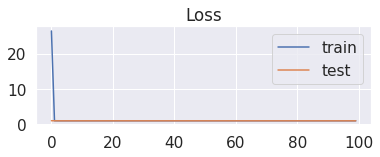

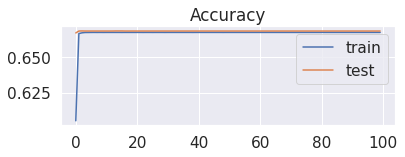

In [66]:
from matplotlib import pyplot
# define and fit model on a training dataset
def fit_model(X_train, y_train, X_test, y_test):
# define model
    model = Sequential()
    model.add(Dense(16, input_shape=(17, ), activation='relu',kernel_regularizer=regularizers.l2(1e-5),kernel_initializer='he_uniform',bias_initializer='zeros'))
    model.add(Dropout(0.5))
    model.add(Dense(32,activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(32,activation='relu'))
    model.add(Dense(5, activation='softmax'))
    # compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    # fit model
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, verbose=0)
    return model, history

# summarize the performance of the fit model
def summarize_model(model, history, X_train, y_train, X_test, y_test):
    # evaluate the model
    _, train_acc = model.evaluate(X_train, y_train, verbose=0)
    _, test_acc = model.evaluate(X_test, y_test, verbose=0)
    print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))
    # plot loss during training
    pyplot.subplot(211)
    pyplot.title('Loss')
    pyplot.plot(history.history['loss'], label='train')
    pyplot.plot(history.history['val_loss'], label='test')
    pyplot.legend()
    plt.show()
    # plot accuracy during training
    pyplot.subplot(212)
    pyplot.title('Accuracy')
    pyplot.plot(history.history['accuracy'], label='train')
    pyplot.plot(history.history['val_accuracy'], label='test')
    pyplot.legend()
    pyplot.show()
model, history = fit_model(X_train, y_train, X_test, y_test)
# evaluate model behavior
summarize_model(model, history, X_train, y_train, X_test, y_test)
# save model to file
#model.save('model.h5')

In [67]:
n_classes = 5

model = Sequential()
model.add(Conv1D(kernel_size = 5, strides=1,filters = 128, activation='relu',input_shape=(17,1)))
                    
print(model.input_shape)
print(model.output_shape)

model.add(MaxPooling1D(pool_size = (2), strides=(2)))
print(model.output_shape)

model.add(Conv1D (kernel_size = 5, strides=1, filters = 256, activation='relu'))
print(model.output_shape)

model.add(MaxPooling1D(pool_size = (2), strides=(2)))
print(model.output_shape)

#.add(Conv1D (kernel_size = 5, strides=1, filters = 128, activation='relu'))
#print(model.output_shape)

#model.add(MaxPooling1D(pool_size = (2), strides=(2)))
#print(model.output_shape)

model.add(Flatten())

print(model.output_shape)

model.add(Dense (64, activation='relu'))
print(model.output_shape)

model.add(Dense(n_classes, activation = 'softmax'))#,activity_regularizer=keras.regularizers.l2()))
print(model.output_shape)

#model.compile( loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(lr=0.01), metrics=[keras.metrics.categorical_accuracy])
model.compile(loss='categorical_crossentropy', optimizer=tensorflow.keras.optimizers.Adam(lr=0.001),metrics=['accuracy'])

(None, 17, 1)
(None, 13, 128)
(None, 6, 128)
(None, 2, 256)
(None, 1, 256)
(None, 256)
(None, 64)
(None, 5)


/env/lib/python3.8/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [68]:
X1 = np.expand_dims(X_train, axis=2)
X2 = np.expand_dims(X_test, axis=2)

Epoch 1/35
576/576 [==============================] - 25s 43ms/step - loss: 10.6944 - accuracy: 0.5147 - val_loss: 1.1319 - val_accuracy: 0.6682
Epoch 2/35
576/576 [==============================] - 25s 43ms/step - loss: 1.1025 - accuracy: 0.6665 - val_loss: 1.0453 - val_accuracy: 0.6683
Epoch 3/35
576/576 [==============================] - 25s 43ms/step - loss: 1.1096 - accuracy: 0.6635 - val_loss: 1.1206 - val_accuracy: 0.6683
Epoch 4/35
576/576 [==============================] - 25s 43ms/step - loss: 1.1037 - accuracy: 0.6645 - val_loss: 1.0611 - val_accuracy: 0.6682
Epoch 5/35
576/576 [==============================] - 25s 43ms/step - loss: 1.0989 - accuracy: 0.6659 - val_loss: 1.1496 - val_accuracy: 0.6682
Epoch 6/35
576/576 [==============================] - 25s 43ms/step - loss: 1.1089 - accuracy: 0.6634 - val_loss: 1.0460 - val_accuracy: 0.6682
Epoch 7/35
576/576 [==============================] - 25s 43ms/step - loss: 1.0704 - accuracy: 0.6670 - val_loss: 1.0355 - val_accuracy

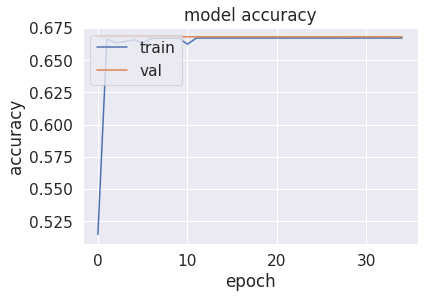

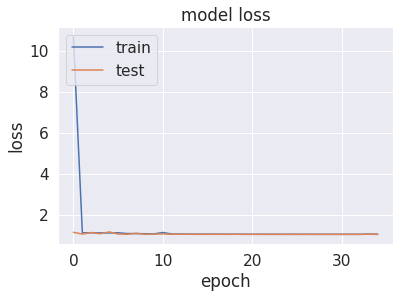

<Figure size 432x288 with 0 Axes>

In [69]:
#model.fit(X1, y_train, epochs=50, batch_size=100)
history= model.fit(X1, y_train,
          epochs=35,
          batch_size=100,
          validation_data=(X2, y_test)
         )
score = model.evaluate(X2, y_test, batch_size=10)
#print("\n%s: %.2f%%" % (model.metrics_names[1], score[1]*100))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.savefig('cov1d')